# Customer Churn - Main Features - LogReg

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import plot_roc_curve, confusion_matrix, roc_auc_score, f1_score

import pickle

import warnings
warnings.filterwarnings("ignore")

In [15]:
def include_timestamps(df):
    """
    @params:
        - df: an initial DataFrame.
    @return:
        - df: a DataFrame including timestamps for months and years.
    """
    df["Year"] = df.index.year
    df["Month"] = df.index.month
    return df

### Reading in and inspecting data

In [16]:
df = pd.read_csv("../data/Tabla_01_English_Unique_postEDA.csv", index_col=0, parse_dates=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4304 entries, 2018-01-31 to 2021-05-31
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Client_ID                              4304 non-null   int64  
 1   Resident_Capital                       4304 non-null   int64  
 2   Client_Age_Years                       4304 non-null   int64  
 3   Client_Sex                             4304 non-null   int64  
 4   Client_Married                         4304 non-null   int64  
 5   Amount_Last_Disbursement               4304 non-null   float64
 6   n(Months)_Since_Last_Disbursement      4304 non-null   int64  
 7   n(Months)_Client_Relationship          4304 non-null   int64  
 8   n(Months)_LO_Active_Employee           4304 non-null   int64  
 9   Client_Status_Post3Months              4304 non-null   int64  
 10  Client_Status_Post6Months              4304 non-null  

### Split data

In [18]:
X = df[["LO_Active_Employee_Post3Months", "LO_Active_Employee_Prior6Months","LO_Active_Employee_Post6Months"]] # features selected based on calculation of feature importance in NB "all features".
y = df["Client_Status_Post3Months"]  
X.shape, y.shape

((4304, 3), (4304,))

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y) 

In [20]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((3443, 3), (3443,), (861, 3), (861,))

### Include timestamps

In [21]:
X_train_timestamped = include_timestamps(X_train)

In [22]:
X_val_timestamped = include_timestamps(X_val)

## Fit and evaluate model

### Fit a Logistic Regression model

In [23]:
# Define weights for cost-sensitive learning.
weights = {0:0.41, 1:0.59}     # rationale: taking inverse distribution of labels (see EDA on distribution of minority/majority groups).


In [24]:
model_LR = LogisticRegression(class_weight = weights, random_state=42) 
model_LR.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.41, 1: 0.59}, random_state=42)

### Make predictions.

In [25]:
ypred_LR = model_LR.predict(X_val)

In [26]:
probs_LR = model_LR.predict_proba(X_val)
probs_LR

array([[0.98119289, 0.01880711],
       [0.07725849, 0.92274151],
       [0.29266401, 0.70733599],
       ...,
       [0.0773578 , 0.9226422 ],
       [0.07715929, 0.92284071],
       [0.77570732, 0.22429268]])

### Evaluate LogReg: ROC curve 

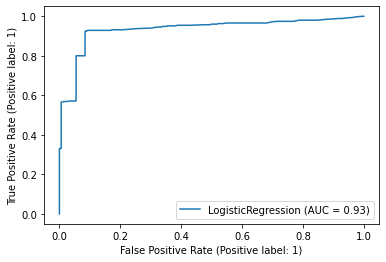

In [27]:
model_LR_disp = plot_roc_curve(model_LR, X_val, y_val)
plt.show()

### Evaluate LogReg: confusion matrix and AUC

In [28]:
print(f"Confusion Matrix: \n{confusion_matrix(y_val, ypred_LR)}")
print(f"Area Under Curve: {roc_auc_score(y_val, ypred_LR).round(2)}")
print(f"f1 - score: {f1_score(y_val, ypred_LR).round(2)}")

Confusion Matrix: 
[[442  69]
 [ 25 325]]
Area Under Curve: 0.9
f1 - score: 0.87


In [29]:
train_accuracy = model_LR.score(X_train, y_train)
train_accuracy

0.8829509148997967

In [30]:
val_accuracy = model_LR.score(X_val, y_val)
val_accuracy

0.8908246225319396

=> model underfits slightly...

### Saving fitted model.

In [31]:
with open("../artefacts/churn-model.bin", "wb") as f_out:
    pickle.dump(model_LR, f_out) 